In [53]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy

In [57]:

# Set random seed
torch.manual_seed(42)

# --- Step 1: Generate and Preprocess Data ---

# Create synthetic dataset with 50 features
X, y = make_classification(n_samples=1000, n_features=50, n_informative=30, 
                           n_redundant=10, random_state=42)

# Standardize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Convert to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1)

# --- Step 2: Create Dataset and Split into Train/Val/Test ---

dataset = TensorDataset(X_tensor, y_tensor)

# 60% train, 20% val, 20% test
total_size = len(dataset)
train_size = int(0.6 * total_size)
val_size = int(0.2 * total_size)
test_size = total_size - train_size - val_size

train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size])

# DataLoaders for batching
batch_size = 32
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size)
test_loader = DataLoader(test_set, batch_size=batch_size)


In [58]:
# --- Step 3: Define Model ---

class NeuralNet(nn.Module):
    def __init__(self, input_dim):
        super(NeuralNet, self).__init__()
        self.hidden1 = nn.Linear(input_dim, 64)
        self.hidden2 = nn.Linear(64, 32)
        self.output = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.relu(self.hidden1(x))
        x = torch.relu(self.hidden2(x))
        x = torch.sigmoid(self.output(x))
        return x

model = NeuralNet(input_dim=50)

# Loss and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [59]:
# --- Step 4: Training Loop with Validation and Batching ---

num_epochs = 50
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    epoch_train_loss = 0.0

    for X_batch, y_batch in train_loader:
        preds = model(X_batch)
        loss = criterion(preds, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item() * X_batch.size(0)

    epoch_train_loss /= train_size
    train_losses.append(epoch_train_loss)

    # Validation
    model.eval()
    epoch_val_loss = 0.0
    with torch.no_grad():
        for X_val, y_val in val_loader:
            val_preds = model(X_val)
            val_loss = criterion(val_preds, y_val)
            epoch_val_loss += val_loss.item() * X_val.size(0)

    epoch_val_loss /= val_size
    val_losses.append(epoch_val_loss)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f}")

Epoch 1/50 | Train Loss: 0.6848 | Val Loss: 0.6703
Epoch 2/50 | Train Loss: 0.6499 | Val Loss: 0.6346
Epoch 3/50 | Train Loss: 0.5953 | Val Loss: 0.5728
Epoch 4/50 | Train Loss: 0.5106 | Val Loss: 0.4959
Epoch 5/50 | Train Loss: 0.4160 | Val Loss: 0.4168
Epoch 6/50 | Train Loss: 0.3344 | Val Loss: 0.3586
Epoch 7/50 | Train Loss: 0.2665 | Val Loss: 0.3205
Epoch 8/50 | Train Loss: 0.2143 | Val Loss: 0.2833
Epoch 9/50 | Train Loss: 0.1718 | Val Loss: 0.2615
Epoch 10/50 | Train Loss: 0.1387 | Val Loss: 0.2390
Epoch 11/50 | Train Loss: 0.1087 | Val Loss: 0.2268
Epoch 12/50 | Train Loss: 0.0862 | Val Loss: 0.2156
Epoch 13/50 | Train Loss: 0.0696 | Val Loss: 0.2126
Epoch 14/50 | Train Loss: 0.0563 | Val Loss: 0.2083
Epoch 15/50 | Train Loss: 0.0469 | Val Loss: 0.2088
Epoch 16/50 | Train Loss: 0.0380 | Val Loss: 0.2099
Epoch 17/50 | Train Loss: 0.0318 | Val Loss: 0.2110
Epoch 18/50 | Train Loss: 0.0274 | Val Loss: 0.2166
Epoch 19/50 | Train Loss: 0.0235 | Val Loss: 0.2188
Epoch 20/50 | Train L

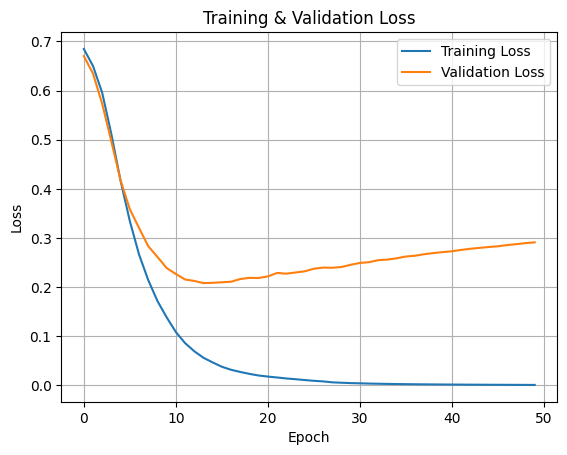

In [ ]:
# --- Step 5: Plot Loss Curves ---

plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [61]:

# --- Step 6: Evaluate on Test Set ---

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for X_test, y_test in test_loader:
        preds = model(X_test)
        labels = (preds >= 0.5).float()
        all_preds.extend(labels.tolist())
        all_labels.extend(y_test.tolist())

test_acc = accuracy_score(all_labels, all_preds)
print(f"\n✅ Test Accuracy: {test_acc * 100:.2f}%")



✅ Test Accuracy: 91.00%
